## SKU Type Classification

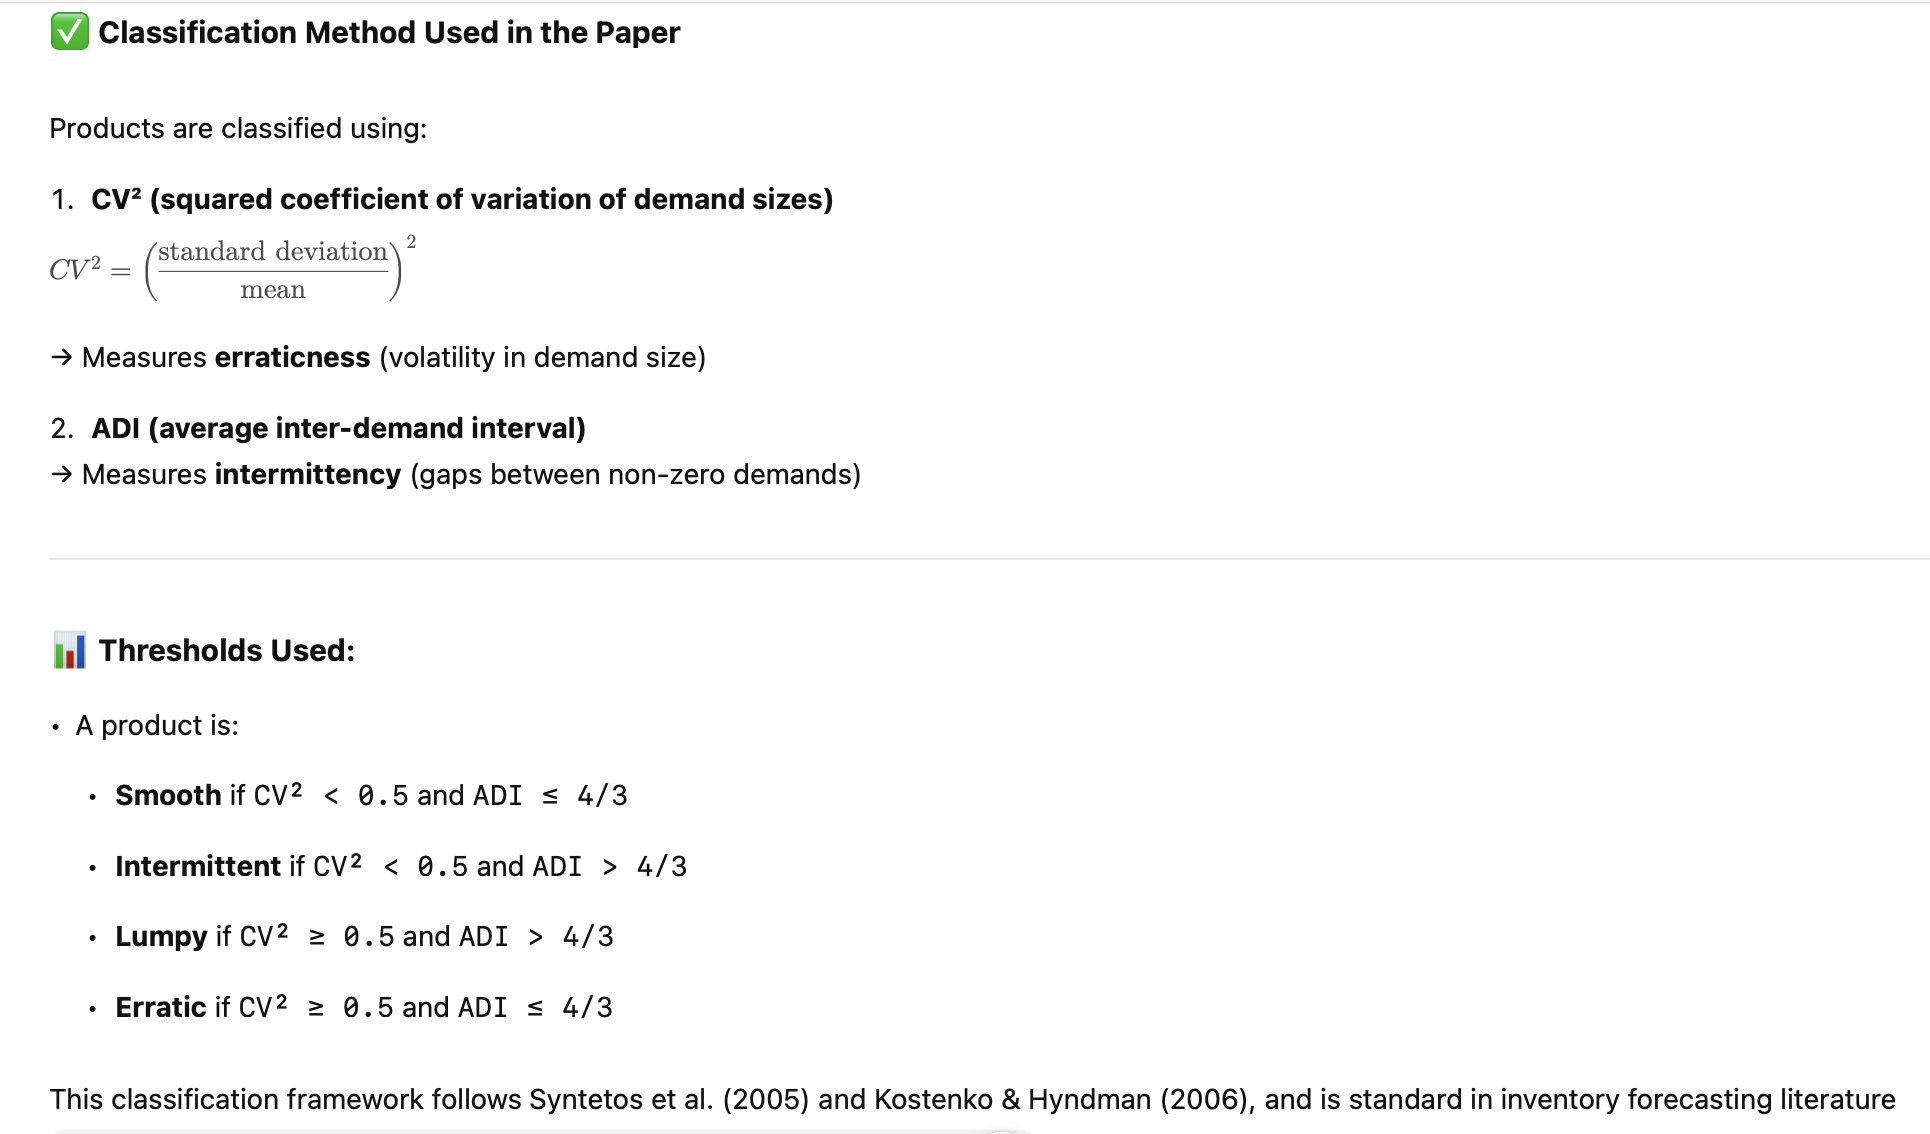

The study categorizes demand series based on their patterns into four classes: smooth, intermittent, lumpy, and erratic. These categories help explain variation in forecast accuracy across different SKUs. Specifically:

“The majority of the series fall in the intermittent class, followed by smooth, while a smaller proportion is classified as lumpy or erratic. As a result, we expect our results to be more relevant for companies that sell products of relatively consistent demand, such as fast-moving food products (smooth) and household goods (intermittent)

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import os

In [2]:
# Load preprocessed data
current_file = os.path.abspath("__file__")
code_dir = os.path.dirname(current_file)
data_dir = os.path.join(os.path.dirname(code_dir), "Data", "Processed")

sales_model = pd.read_pickle(os.path.join(data_dir, "lgbm_state_evaluation_data.pkl"))

In [43]:
sales_model.sample(5)

,state_id,item_id,d,date,wm_yr_wk,sales,lag_7,lag_28,rmean_7,rmean_28,avg_sell_price,day,weekday,month,year
15918982,WI,HOUSEHOLD_1_105,d_842,2013-05-19,11317,0,0.0,1.0,0.000000,0.107143,4.042947,19,6,5,2013
11032127,TX,HOUSEHOLD_2_101,d_1425,2014-12-23,11447,0,0.0,0.0,0.571429,0.214286,4.490000,23,1,12,2014
1569339,CA,FOODS_3_196,d_1012,2013-11-05,11341,2,1.0,4.0,4.142857,4.178571,4.495436,5,1,11,2013
15645253,WI,HOBBIES_2_110,d_794,2013-04-01,11310,0,0.0,0.0,0.142857,0.285714,5.970000,1,0,4,2013
11082811,TX,HOUSEHOLD_2_127,d_1643,2015-07-29,11526,1,1.0,1.0,1.000000,0.857143,5.858562,29,2,7,2015


### Classification of the 4 SKUs

In [3]:
# get all unique values of the column 'item_id'
# item_ids = sales_model['item_id'].unique()
# state_ids = sales_model['state_id'].unique()

item_ids = [
    "FOODS_3_819", "FOODS_3_090",
    "HOBBIES_1_234", "HOUSEHOLD_1_118"
]
state_ids = ['TX'] 

filtered_sales_model = sales_model[
    (sales_model['item_id'].isin(item_ids)) &
    (sales_model['state_id'].isin(state_ids))
]

results = []
grouped = filtered_sales_model.groupby(['item_id', 'state_id'])

for (item, state), group in grouped:
    sales = group['sales'].values

    # Inter-demand intervals
    non_zero_indices = np.where(sales > 0)[0]
    if len(non_zero_indices) < 2:
        adi = np.inf
    else:
        intervals = np.diff(non_zero_indices)
        adi = np.mean(intervals)

    # CV^2 calculation
    demand_sizes = sales[sales > 0]
    if len(demand_sizes) < 2 or np.mean(demand_sizes) == 0:
        cv2 = np.inf
    else:
        cv2 = (np.std(demand_sizes) / np.mean(demand_sizes)) ** 2

    # Classification
    if cv2 < 0.5 and adi <= 4/3:
        demand_type = 'smooth'
    elif cv2 < 0.5 and adi > 4/3:
        demand_type = 'intermittent'
    elif cv2 >= 0.5 and adi > 4/3:
        demand_type = 'lumpy'
    else:
        demand_type = 'erratic'


    results.append({
        'id': f'{item}_{state}',
        'ADI': adi,
        'CV2': cv2,
        'demand_type': demand_type
    })



In [4]:
print(pd.DataFrame(results))

                   id       ADI       CV2 demand_type
0      FOODS_3_090_TX  1.153794  0.235276      smooth
1      FOODS_3_819_TX  1.154589  0.793125     erratic
2    HOBBIES_1_234_TX  1.629377  1.008827       lumpy
3  HOUSEHOLD_1_118_TX  1.002622  0.283824      smooth


### Classification of all SKUs

In [31]:
# get all unique values of the column 'item_id'
item_ids = sales_model['item_id'].unique()
state_ids = sales_model['state_id'].unique()

results = []

grouped = sales_model.groupby(['item_id', 'state_id'])

for (item, state), group in grouped:
    sales = group['sales'].values

    # Inter-demand intervals
    non_zero_indices = np.where(sales > 0)[0]
    if len(non_zero_indices) < 2:
        adi = np.inf
    else:
        intervals = np.diff(non_zero_indices)
        adi = np.mean(intervals)

    # CV^2 calculation
    demand_sizes = sales[sales > 0]
    if len(demand_sizes) < 2 or np.mean(demand_sizes) == 0:
        cv2 = np.inf
    else:
        cv2 = (np.std(demand_sizes) / np.mean(demand_sizes)) ** 2

    # Classification
    if cv2 < 0.5 and adi <= 4/3:
        demand_type = 'smooth'
    elif cv2 < 0.5 and adi > 4/3:
        demand_type = 'intermittent'
    elif cv2 >= 0.5 and adi > 4/3:
        demand_type = 'lumpy'
    else:
        demand_type = 'erratic'


    results.append({
        'id': f'{item}_{state}',
        'ADI': adi,
        'CV2': cv2,
        'demand_type': demand_type
    })



In [33]:
# summarize the number of SKUs in each demand type
demand_type_summary = pd.DataFrame(results).groupby('demand_type').size().reset_index(name='count')
print(demand_type_summary)

    demand_type  count
0       erratic    687
1  intermittent   4144
2         lumpy   1098
3        smooth   3218
